In [1]:
import pandas as pd
import feature_engineering
import quadratic_weighted_kappa

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

%reload_ext autoreload
%autoreload 2

C:\Users\alexg\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv('data_minus_images/train.csv')

In [3]:
pet_df = feature_engineering.add_everything(data)

In [4]:
pet_df.head()

,PetID,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,score,language,BreedName,BreedGroup,BreedGroupID,purebred,desc_len,start_cap,num_colors,has_name
0,86e1089a3,2,Nibble,3,299,0,1,1,7,0,...,0.3,en,Tabby,CAT,-1,1,359,1,2,1
1,1bf1f95ef,2,Mimi,12,299,0,2,3,6,7,...,0.0,None,Tabby,CAT,-1,1,40,1,3,1
2,987baa1c7,2,Tabby Male,48,299,0,1,1,2,7,...,0.3,en,Tabby,CAT,-1,1,707,1,3,1
3,5c546c236,2,Manja,4,299,0,2,1,2,0,...,0.4,en,Tabby,CAT,-1,1,130,1,2,1
4,c2346525a,2,Cham,8,299,0,1,3,0,0,...,0.5,en,Tabby,CAT,-1,1,99,1,1,1


In [5]:
X = pet_df.drop(columns=['Name','RescuerID','Description','PetID','AdoptionSpeed', 'BreedName', 'BreedGroupID'])
y = pet_df['AdoptionSpeed'].astype('str')

In [6]:
cat_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State', 'language', 'BreedGroup']

In [7]:
for feat in cat_features:
    dummies = pd.get_dummies(X[feat], prefix=feat)
    dummies.drop(dummies.columns[-1], axis=1, inplace=True)
    X = X.drop(feat, axis=1).merge(dummies, left_index=True, right_index=True)

In [8]:
y_one = pd.get_dummies(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
X_train.shape[1]

370

In [185]:
nn = Sequential()

# input layer
nn.add(Dense(370, activation='relu', input_dim=(X_train.shape[1])))

# hidden lyaers
nn.add(Dropout(0.5))
nn.add(Dense(256, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(64, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(4, activation='relu'))

# output layer
nn.add(Dense(1,activation='linear'))

nn.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(), metrics=['mae'])

trained = nn.fit(X_train, y_train, batch_size=64,epochs=50,verbose=1,validation_data=(X_test, y_test))

nn.evaluate(X_test, y_test)

Train on 11990 samples, validate on 2998 samples
Epoch 1/50
11990/11990 [==============================] - 4s 356us/step - loss: 3.8599 - mean_absolute_error: 3.8599 - val_loss: 2.3459 - val_mean_absolute_error: 2.3459
Epoch 2/50
11990/11990 [==============================] - 2s 158us/step - loss: 2.1540 - mean_absolute_error: 2.1540 - val_loss: 1.9795 - val_mean_absolute_error: 1.9795
Epoch 3/50
11990/11990 [==============================] - 2s 141us/step - loss: 1.7813 - mean_absolute_error: 1.7813 - val_loss: 1.4949 - val_mean_absolute_error: 1.4949
Epoch 4/50
11990/11990 [==============================] - 3s 221us/step - loss: 1.4378 - mean_absolute_error: 1.4378 - val_loss: 1.2841 - val_mean_absolute_error: 1.2841
Epoch 5/50
11990/11990 [==============================] - 3s 213us/step - loss: 1.2100 - mean_absolute_error: 1.2100 - val_loss: 1.0557 - val_mean_absolute_error: 1.0557
Epoch 6/50
11990/11990 [==============================] - 3s 217us/step - loss: 1.1034 - mean_absolut

[0.9522136881639355, 0.9522136881639355]

In [186]:
y_predict = nn.predict(X_test)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023DDD0275C0>]],
      dtype=object)

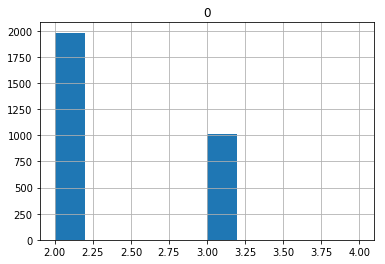

In [187]:
y_predict = y_predict.reshape((1,-1)).round()[0]
pd.DataFrame(y_predict).hist()

In [188]:
quadratic_weighted_kappa.quadratic_weighted_kappa(y_predict, y_test)

0.15522688838956833

In [189]:
y_predict = nn.predict(X_test)

In [190]:
y_predict

array([[2.0268319],
       [2.026585 ],
       [2.0313668],
       ...,
       [2.024459 ],
       [2.9444447],
       [2.0250626]], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023DCF488668>]],
      dtype=object)

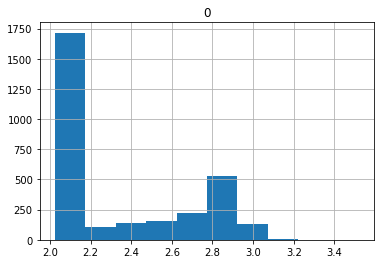

In [191]:
pd.DataFrame(y_predict).hist(bins=10)

In [192]:
y_predict_2 = y_predict.copy()
y_predict_2[y_predict>2] = 1
y_predict_2[y_predict>2.04] = 2
y_predict_2[y_predict>2.4] = 3
y_predict_2[y_predict>3.009] = 4
y_predict_2

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [3.],
       [1.]], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023DDD30B080>]],
      dtype=object)

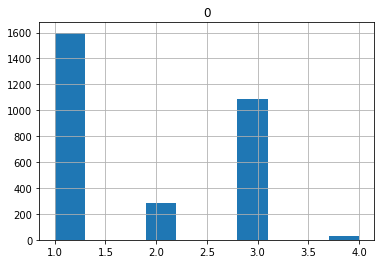

In [193]:
y_predict_2 = y_predict_2.reshape((1,-1)).round()[0]
pd.DataFrame(y_predict_2).hist()

In [194]:
quadratic_weighted_kappa.quadratic_weighted_kappa(y_predict_2, y_test)

0.19026808739250578